In [1]:
# import dependencies
import torch
from huggingface_hub import login
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset, Image
from transformers import AutoProcessor
from transformers import AutoModelForCausalLM
from evaluate import load
from transformers import TrainingArguments, Trainer
import requests
from gtts import gTTS 
import os
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from torchvision import transforms as T

# Empty GPU cache
torch.cuda.empty_cache()

In [ ]:
# login to huggingface
login(token="your_hf_token")

In [3]:
# specify path to custom dataset
data_dir = 'flickr8k'
image_dir = f'{data_dir}/Images'
csv_file = f'{data_dir}/captions.csv'


In [ ]:
ds = load_dataset("csv", data_files=csv_file, sep=",")
original_train_ds = ds["train"]

# Function to keep only every 5th row
def keep_every_fifth(example, idx):
    return idx % 5 == 0

# Apply the filter function
filtered_train_ds = original_train_ds.filter(keep_every_fifth, with_indices=True)

# Perform the train-test split
ds = filtered_train_ds.train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]
def update_image(row):
    image_path = image_dir+'/'+row['image']
    row['image'] = image_path
    return row

train_ds = train_ds.map(update_image).cast_column("image", Image())
test_ds = test_ds.map(update_image).cast_column("image", Image())
ds


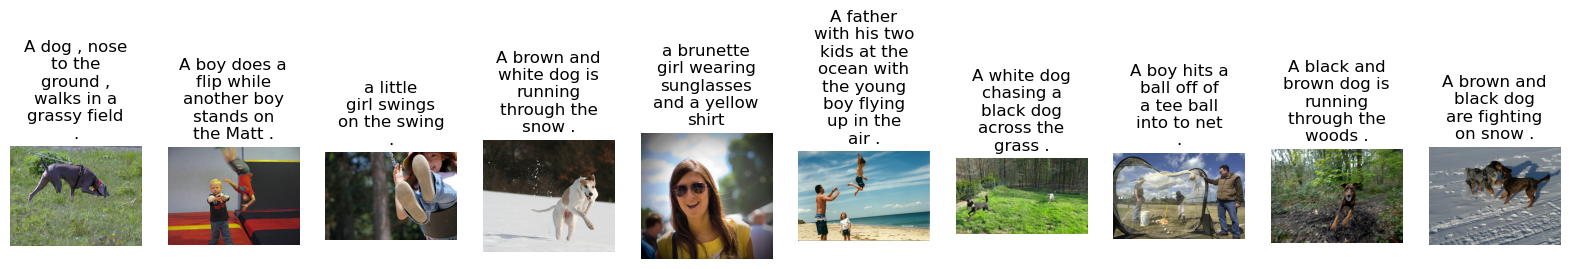

In [5]:
from PIL import Image


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(10)]
sample_captions = [train_ds[i]["caption"] for i in range(10)]
plot_images(sample_images_to_visualize, sample_captions)

In [6]:
checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

In [7]:
def resize_to_half_size(image):
    # Calculate new size, reducing both dimensions to 1/4
    new_width = image.width // 2
    new_height = image.height // 2
    return image.resize((new_width, new_height))

# Apply resizing and conversion to tensor
image_transform = T.Compose([
    T.Lambda(resize_to_half_size),  # Apply custom resize
    T.ToTensor(),  # Convert images to PyTorch tensors
])

def transforms(example_batch):
    # Process and resize images
    resized_images = [image_transform(Image.fromarray(image)) if not isinstance(image, Image.Image) else image_transform(image) for image in example_batch["image"]]
    image_inputs = processor(images=resized_images, return_tensors="pt")

    # Process captions
    text_inputs = processor(text=example_batch["caption"], padding="max_length", return_tensors="pt")

    # Combine the outputs
    inputs = {**image_inputs, **text_inputs}
    # Update labels for training
    inputs.update({"labels": text_inputs["input_ids"]})
    return inputs

train_ds.set_transform(transforms)
test_ds.set_transform(transforms)


In [8]:
#loading model
model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [9]:
#only finetune output layer because of overfitting
for name, param in model.named_parameters():
    if 'output' not in name:  
        param.requires_grad = False
    else: 
        param.requires_grad = True
        
for name, param in model.named_parameters():
    if param.requires_grad:
        # print(f"Layer: {name}, Status: Fine-tuned (Trainable)")
        pass

In [10]:
# compute metrics to see how well the model is doing
wer = load("wer")
bleu = load("bleu")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    bleu_score = bleu.compute(predictions=decoded_predictions, references=decoded_labels)["bleu"]
    return {"wer_score": wer_score, "blue_score": bleu_score}

In [11]:
model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-10000",
    learning_rate=5e-5,
    num_train_epochs=2,
    fp16=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=4,
    save_total_limit=1,
    evaluation_strategy="steps",
    eval_steps=35,
    save_strategy="steps",
    save_steps=35,
    logging_steps=35,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

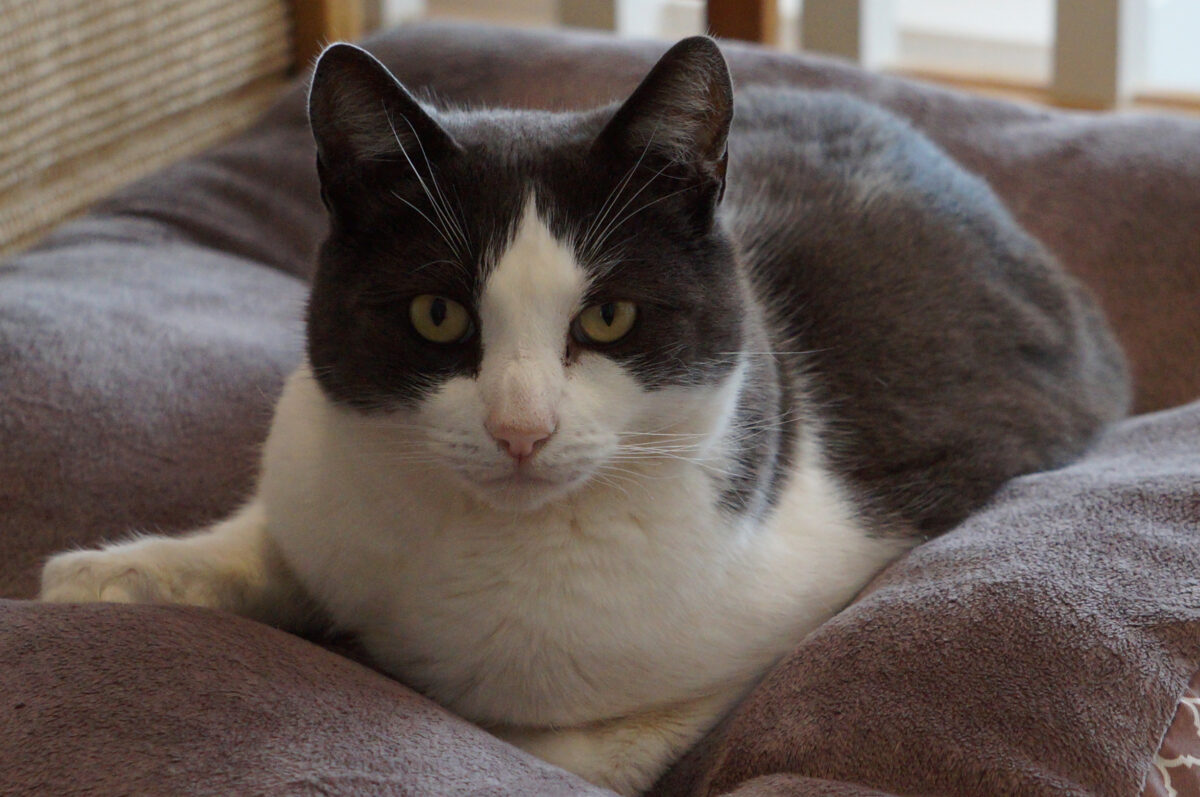

In [14]:
image = Image.open("kittie.jpg")

# preprocess the image
device = "cuda" if torch.cuda.is_available() else "cpu"
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

# generate promt from image with our model
generated_ids = model.generate(pixel_values=pixel_values, max_length=300)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

language = 'en'

myobj = gTTS(text=generated_caption, lang=language, slow=False) 
  

myobj.save("demo/kittie.mp3") 
image

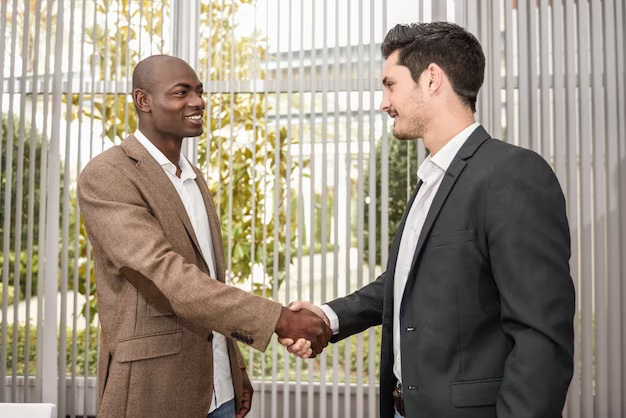

In [15]:
image = Image.open("men_greeting.jpg")

# preprocess the image
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

# generate promt from image with our model
generated_ids = model.generate(pixel_values=pixel_values, max_length=300)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

language = 'en'

myobj = gTTS(text=generated_caption, lang=language, slow=False) 
   
myobj.save("demo/men_greeting.mp3") 
image

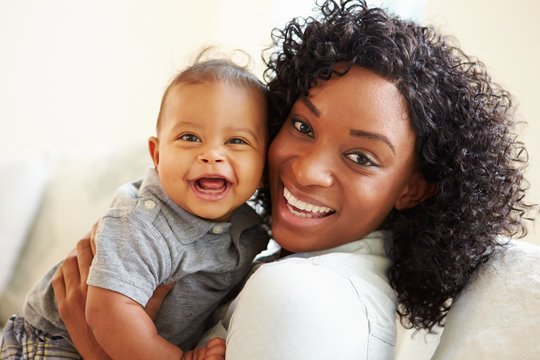

In [16]:
image = Image.open("mother_holding_baby.jpg")

# preprocess the image
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

# generate promt from image with our model
generated_ids = model.generate(pixel_values=pixel_values, max_length=300)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

language = 'en'

myobj = gTTS(text=generated_caption, lang=language, slow=False) 
  

myobj.save("demo/mother_holding_baby.mp3") 
image

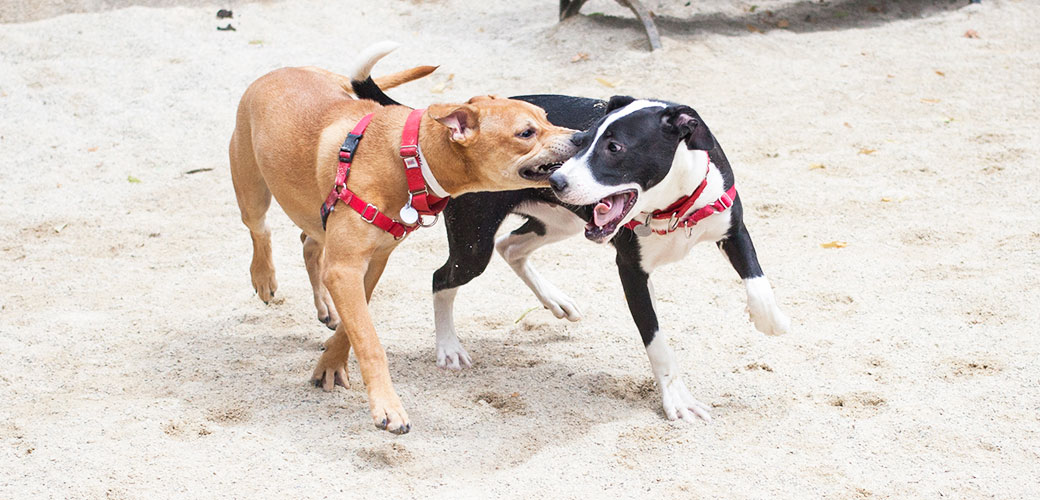

In [17]:
image = Image.open("beach_dogs.jpg")

# preprocess the image
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

# generate promt from image with our model
generated_ids = model.generate(pixel_values=pixel_values, max_length=300)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

language = 'en'

myobj = gTTS(text=generated_caption, lang=language, slow=False) 

myobj.save("demo/beach_dogs.mp3") 
image


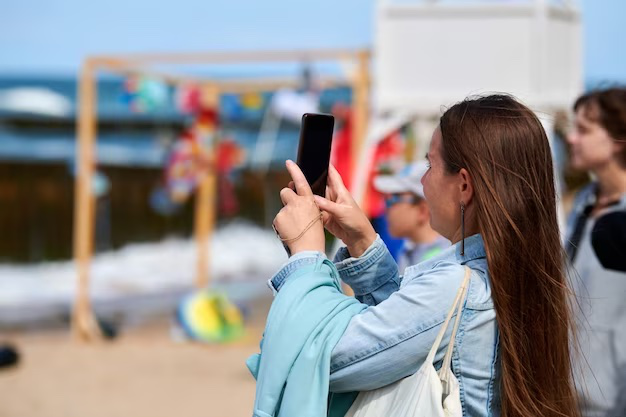

In [18]:
image = Image.open("women_with_phone.jpg")

# preprocess the image
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

# generate promt from image with our model
generated_ids = model.generate(pixel_values=pixel_values, max_length=300)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

language = 'en'

myobj = gTTS(text=generated_caption, lang=language, slow=False) 
   
myobj.save("demo/women_with_phone.mp3") 
image